# Importing Modules and Defining Functions

In [52]:
import sys
import requests
import numpy as np
import pandas as pd
from json import loads
from textwrap import wrap
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

In [53]:
def httpsReq(requestAddr):

    #Making the API Request
    # print(f'Making API Call to: {requestAddr}')
    response = requests.get(requestAddr)
    if response.status_code == 200:
        pass
    elif response.status_code != 200:
        print(f'{response.status_code} - API Request {requestAddr} Failed')
        KeyboardInterrupt

    #Converting JSON to Dict and Parsing API Data into a Dataframe
    api_dict = loads(response.text)

    return api_dict

In [54]:
#Function for Writing .xlsx Data Tables which will provide a standard output for table formatting 
def xlsx_table_writer(data_table,sheet_name,col_width_list,title_str,startrow,startcol,worksheet,workbook,writer):

    #Layout/Formatting
    t_vert_spacing = 5 #Vertical Spacing between tables
    t_horz_spacing = 1 #Horizontal Spacing between tables
    title_format = workbook.add_format({'bold': True, 'font_size' : 20, 'fg_color' : '#76933C', 'font_color' : 'white' }) #Standardised Title Format for all tables
    header_format = workbook.add_format({'bold' : True, 'font_size' : 12, 'text_wrap' : True}) #text-wrapping for table headers
    
    # Adding and changing active sheet
    try:
        worksheet=workbook.add_worksheet(sheet_name)
        writer.sheets[sheet_name] = worksheet 
        worksheet.set_zoom(70)
        startrow = 3
        startcol = 1
    except:
        pass

    for i in range(len(col_width_list)):
        worksheet.set_column(i+startcol, i+startcol, col_width_list[i])

    #Writing in Cell Data and Merging Cells for Table Titles
    data_table.to_excel(writer,sheet_name=sheet_name,startrow=startrow , startcol=startcol, index=False, header=False)
    worksheet.merge_range(startrow-2, startcol,startrow-2,data_table.shape[1] + startcol -1, title_str,title_format) #writing in title formatting above table

    #Column settings to use in add table function
    column_settings = [{'header' : column} for column in data_table.columns]

    #Populating Excel with Table Format - Adding table to xls for each df
    worksheet.add_table(startrow-1, startcol, startrow + data_table.shape[0], data_table.shape[1] + startcol - 1, {'columns' : column_settings, 'style': 'Table Style Medium 4', 'autofilter' : False})   

    #Applying a text wrap to the Column Header
    for col_num, value in enumerate(data_table.columns.values):
        worksheet.write(startrow-1, col_num + startcol, value, header_format)
    
    #Setting Positions of Following Tables Insertions
    startrow = startrow + data_table.shape[0] + t_vert_spacing #Setting to start row for next table
    # startrow = 3  
    # startcol = startcol + data_table.shape[1] + t_horz_spacing  #Disabling horizontally displaced tables in favour of vertically displacements
    startcol = 1

    #Setting the column width at the end of the table to keep to spacing minimal between tables
    worksheet.set_column(startcol-1,startcol-1,1)
    
    #Return the start row in order to index for future function calls
    return [startrow,startcol,worksheet,workbook,writer]

# Requesting Game History via Chess.com API
### We need to stage our api request to transform into a dataframe:
- The api request address only returns the games for the selected month and year
- There we must pull down our archive histotry and loop through the api requests to return data for each month

In [55]:
#Retrieveing Archive of My Entire Chess.com History
today_str = date.today().strftime('%d-%b-%y')
player = 'Hikaru'
last_x_months = 12
archive_dict = httpsReq(f'https://api.chess.com/pub/player/{player.lower()}/games/archives')
print(f'API Request for Monthly API Endpoints Successful')
archive = (archive_dict['archives'])
archive = archive[-last_x_months:]
archive 

API Request for Monthly API Endpoints Successful


['https://api.chess.com/pub/player/hikaru/games/2023/03',
 'https://api.chess.com/pub/player/hikaru/games/2023/04',
 'https://api.chess.com/pub/player/hikaru/games/2023/05']

In [56]:
api_list = [httpsReq(request) for request in archive]
print(f'API Request Successful and Appended all request links together')

API Request Successful and Appended all request links together


## Unpacking List of Games

In [57]:
game_list = []
print('Transforming JSON data into a dataframe')
for month in api_list: 
    month_of_games = month['games']
    for game in month_of_games: 
        game_list.append(game)
df = pd.DataFrame(game_list)

Transforming JSON data into a dataframe


### Filtering the rule set strictly to 'chess'
- There are other subsets of rules such as **'crazyhouse'** which add columns to the pgn and alter the shape of the table - *we just want the defualt chess pgn's*
- Crazyhouse rules add cols 23,24,25 which relate to the "Varient URL", "unknown blank col", "varient chess moves"
- df.loc[df['rules']=='crazyhouse']

In [58]:
df = df.loc[df['rules']=='chess']
df.reset_index(drop=True,inplace=True)
df.head(3)

,url,pgn,time_control,end_time,rated,accuracies,tcn,uuid,initial_setup,fen,time_class,rules,white,black,tournament
0,https://www.chess.com/game/live/71424744779,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180,1677685826,True,"{'white': 82.16, 'black': 76.83}",gvZJjr!Tcj6Lmu0SlB3VftLtdt5ZblYIecIBvB90cbZItm...,312cf80a-b848-11ed-9170-6cfe544c0428,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,r5k1/4bpp1/4p2p/2N1P3/1Pq2P2/P2Q2P1/1K5P/3R4 b...,blitz,chess,"{'rating': 3250, 'result': 'win', '@id': 'http...","{'rating': 2934, 'result': 'resigned', '@id': ...",NaN
1,https://www.chess.com/game/live/71424916679,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180,1677686131,True,"{'white': 77.29, 'black': 81.77}",lB!TkA0SgvZJbs9zcM3VMT7TdrzsrsYQmu5ZfmJAmA8!eg...,c9685fdc-b848-11ed-9170-6cfe544c0428,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,8/4k1p1/7p/7P/4r1RK/8/6b1/8 w - -,blitz,chess,"{'rating': 2932, 'result': 'resigned', '@id': ...","{'rating': 3252, 'result': 'win', '@id': 'http...",NaN
2,https://www.chess.com/game/live/71425318561,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",180,1677686470,True,"{'white': 90.5, 'black': 83.37}",gvZJjr6Lmu0Scj!TlB90ft8!eg5ZkAYQbs0ztLSLAJzsjs...,7f416a21-b849-11ed-9170-6cfe544c0428,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,8/3P3P/4kP2/8/1B6/P4K2/5P2/3r4 b - -,blitz,chess,"{'rating': 3254, 'result': 'win', '@id': 'http...","{'rating': 2930, 'result': 'resigned', '@id': ...",NaN


#### Saving NaN Accurracy URL Links

In [59]:
# You need to analyse the game on chess.com website for the data to appear in the corresponding PGN/game
# Need to make some kind of webscraper to page through all the URL's and analyse all the games
df_acc = df.loc[df['accuracies'].isna()==True]
# df_acc['url'].to_csv('data/accuracy_nan_url.csv',index=False)
df_acc.shape[0]
# df_acc.head(5)

1

#### Creating a subset of data with select headers (Used later to merge in with pgn data)

In [60]:
df_subset_attributes = df.loc[:,['url','rated','rules','time_class']]

# Re-naming the url column to enable a merging criterion down the script for the pgn table
if 'url' in df_subset_attributes.columns:
    df_subset_attributes.rename(columns={'url':'Link'},inplace=True)

df_subset_attributes[:3]

,Link,rated,rules,time_class
0,https://www.chess.com/game/live/71424744779,True,chess,blitz
1,https://www.chess.com/game/live/71424916679,True,chess,blitz
2,https://www.chess.com/game/live/71425318561,True,chess,blitz


#### Cleaning pgn data in preparation for putting into dataframe
- Splitting new lines into lists
- Brackets and slashed removed

In [61]:
pgn_list = [df.loc[i,'pgn'].splitlines(False) for i in range(df.shape[0])] #splitting newlines into list structure

for i,pgn in enumerate(pgn_list):

    for j in range(len(pgn)):
        pgn_list[i][j] = pgn_list[i][j].split(' \"')

        for k in range(len(pgn_list[i][j])):
            pgn_list[i][j][k] = pgn_list[i][j][k].replace('\"','')
            pgn_list[i][j][k] = pgn_list[i][j][k].replace('[','')
            pgn_list[i][j][k] = pgn_list[i][j][k].replace(']','')

#### Flatten List of Pgn's, Extracting Only the Headers We Want

In [62]:
pgn_headers = [
    'Event', 'Date', 'Round', 'White', 'Black', 'Result', 'Timezone', 'ECO', 'ECOUrl', 'WhiteElo', 'BlackElo', 'TimeControl', 'Termination', 'StartTime', 'EndDate', 'EndTime', 'Link'
]
# Flattening
pgn_list = [list_pair for pgn in pgn_list for list_pair in pgn]

# Reducing List Size
consolidated_pgn = []
for h in pgn_headers:
    pgn_col = [pgn_list[i][1] for i in range(len(pgn_list)) if pgn_list[i][0] in [h]]
    consolidated_pgn.append(pgn_col)

In [63]:
len(consolidated_pgn)

17

#### Creating PGN DataFrame

In [64]:
df_pgn = pd.DataFrame(consolidated_pgn).T
df_pgn.columns = pgn_headers
df_pgn.head(3)

,Event,Date,Round,White,Black,Result,Timezone,ECO,ECOUrl,WhiteElo,BlackElo,TimeControl,Termination,StartTime,EndDate,EndTime,Link
0,Live Chess,2023.03.01,-,Hikaru,Chesswizard_2007,1-0,UTC,A06,https://www.chess.com/openings/Reti-Opening-Ni...,3250,2934,180,Hikaru won by resignation,15:46:06,2023.03.01,15:50:26,https://www.chess.com/game/live/71424744779
1,Live Chess,2023.03.01,-,Chesswizard_2007,Hikaru,0-1,UTC,D30,https://www.chess.com/openings/Queens-Gambit-D...,2932,3252,180,Hikaru won by resignation,15:50:18,2023.03.01,15:55:31,https://www.chess.com/game/live/71424916679
2,Live Chess,2023.03.01,-,Hikaru,Chesswizard_2007,1-0,UTC,A06,https://www.chess.com/openings/Reti-Opening-Ni...,3254,2930,180,Hikaru won by resignation,15:55:24,2023.03.01,16:01:10,https://www.chess.com/game/live/71425318561


#### Replace Opening URL's with Chess Opening Names

In [65]:
df_pgn['ECOUrl'] = df_pgn['ECOUrl'].str.replace('https://www.chess.com/openings/','',regex=True)
df_pgn['ECOUrl'] = df_pgn['ECOUrl'].str.replace('-',' ',regex=True)
if 'ECOUrl' in df_pgn.columns:
    df_pgn.rename(columns={'ECOUrl':'Opening'},inplace=True)

#### Transform Date Columns into Datetime datatype
- And also extract hourly/day of week data

In [66]:
# # Converting to Datetime Format
df_pgn['Date'] = pd.to_datetime(df_pgn['Date'])
df_pgn['EndDate'] = pd.to_datetime(df_pgn['EndDate'])
df_pgn['Hour'] = df_pgn['EndTime'].str.slice(stop=2).astype(int)
df_pgn['Day Name'] = df_pgn['Date'].dt.day_name()

#### Merging chess pgn dataframe back into the main dataframe via the game url/link

In [67]:
df_original = pd.merge(df_pgn,df_subset_attributes,on='Link',how='inner')

In [68]:
set(df_original['TimeControl'])
set(df_original['time_class'])

{'blitz', 'bullet', 'rapid'}

#### Determining Game Result And Rating For Selected Player per Game

In [69]:
result_list = []
end_state_list = []
player_rating_list = []
opponent_rating_list = []
state_list = ['50-move rule','agreement','by timeout vs insufficient material','by insufficient material','repetition','stalemate','abandoned','checkmate','resignation','time']

for words in df_original['Termination']:

    # Win/Loss/Draw
    if f'{player} won' in words:
        result_list.append('Win')
    elif 'drawn' in words:
        result_list.append('Draw')
    else:
        result_list.append('Loss')

    # End State
    for state in state_list:
        if state in words:
            end_state_list.append(state)
            break

# Extracting Player Rating
for i in range(df_original.shape[0]):
    if df_original.loc[i,'White'] == player:
        player_rating_list.append(int(df_original.loc[i,'WhiteElo']))
        opponent_rating_list.append(int(df_original.loc[i,'BlackElo']))
    elif df_original.loc[i,'Black'] == player:
        player_rating_list.append(int(df_original.loc[i,'BlackElo']))
        opponent_rating_list.append(int(df_original.loc[i,'WhiteElo']))

df_original['Game Result'] = result_list
df_original['End State'] = end_state_list
df_original['Player Rating'] = player_rating_list
df_original['Opponent Rating'] = opponent_rating_list

df_original[:3]

,Event,Date,Round,White,Black,Result,Timezone,ECO,Opening,WhiteElo,...,Link,Hour,Day Name,rated,rules,time_class,Game Result,End State,Player Rating,Opponent Rating
0,Live Chess,2023-03-01,-,Hikaru,Chesswizard_2007,1-0,UTC,A06,Reti Opening Nimzowitsch Larsen Attack 2...Nf6...,3250,...,https://www.chess.com/game/live/71424744779,15,Wednesday,True,chess,blitz,Win,resignation,3250,2934
1,Live Chess,2023-03-01,-,Chesswizard_2007,Hikaru,0-1,UTC,D30,Queens Gambit Declined 3.Nf3 Nf6,2932,...,https://www.chess.com/game/live/71424916679,15,Wednesday,True,chess,blitz,Win,resignation,3252,2932
2,Live Chess,2023-03-01,-,Hikaru,Chesswizard_2007,1-0,UTC,A06,Reti Opening Nimzowitsch Larsen Attack 2...Bf5,3254,...,https://www.chess.com/game/live/71425318561,16,Wednesday,True,chess,blitz,Win,resignation,3254,2930


In [70]:
type(df_original.loc[0,'Player Rating'])

numpy.int64

In [71]:
print(f'There are {df_original.shape[1]} cols:\n{list(df_original.columns)}')

There are 26 cols:
['Event', 'Date', 'Round', 'White', 'Black', 'Result', 'Timezone', 'ECO', 'Opening', 'WhiteElo', 'BlackElo', 'TimeControl', 'Termination', 'StartTime', 'EndDate', 'EndTime', 'Link', 'Hour', 'Day Name', 'rated', 'rules', 'time_class', 'Game Result', 'End State', 'Player Rating', 'Opponent Rating']


In [72]:
curated_columns = [
    'Date',
    'White',
    'Black',
    'Opening',
    'WhiteElo',
    'BlackElo',
    'TimeControl',
    'Termination',
    'StartTime',
    'EndDate',
    'EndTime',
    'Hour',
    'Day Name',
    'rated',
    'time_class',
    'Game Result',
    'End State',
    'Player Rating',
    'Opponent Rating'
]

xlsx_columns = [
    'Date',
    'White',
    'Black',
    'Opening',
    'TimeControl',
    'Termination',
    'time_class',
    'Game Result',
    'End State',
    'Player Rating',
    'Opponent Rating'
]

df_curated = df_original[curated_columns]
print(f'There are {df_curated.shape[1]} curated cols:\n{list(df_curated.columns)}')

There are 19 curated cols:
['Date', 'White', 'Black', 'Opening', 'WhiteElo', 'BlackElo', 'TimeControl', 'Termination', 'StartTime', 'EndDate', 'EndTime', 'Hour', 'Day Name', 'rated', 'time_class', 'Game Result', 'End State', 'Player Rating', 'Opponent Rating']


#### Filtering Ranked Games

In [73]:
# Filtering Down to Rated Games to specific time classifications
df_blitz = df_curated.loc[
                                    (df_curated['time_class']=='blitz') 
                                  # & (df_curated['TimeControl']=='180+2')
                                  & (df_curated['rated'] == True)
                                  ].reset_index(drop=True)
df_blitz[-3:]

,Date,White,Black,Opening,WhiteElo,BlackElo,TimeControl,Termination,StartTime,EndDate,EndTime,Hour,Day Name,rated,time_class,Game Result,End State,Player Rating,Opponent Rating
801,2023-05-04,Hikaru,Msb2,Kings Indian Attack 2...e6,3254,3019,180,Hikaru won on time,19:35:46,2023-05-04,19:42:12,19,Thursday,True,blitz,Win,time,3254,3019
802,2023-05-04,Msb2,Hikaru,Nimzo Indian Defense Normal Line...5.Bd2 b6 6....,3032,3241,180,Msb2 won by resignation,19:42:00,2023-05-04,19:47:24,19,Thursday,True,blitz,Loss,resignation,3241,3032
803,2023-05-04,Hikaru,Msb2,French Defense Knight Variation Two Knights Va...,3245,3028,180,Hikaru won by resignation,19:47:14,2023-05-04,19:52:26,19,Thursday,True,blitz,Win,resignation,3245,3028


## Applying Data Aggregation Techniques

In [74]:
def percentage_string(value):
    return "{:.1%}".format(value)

In [75]:
def chart_annotation(df,value_label,ax,chart_type):
    #Text Annotations
    [r,g,b] = [.3,.65,.85]
    [lw,pad] = [0.2,1.2]

    for i,count in enumerate(df[value_label]):
        if count > 0:
            if chart_type == 'bar': 
                ax.text(i,count,int(count),fontsize=8,color='white',weight='bold',bbox=dict(fc=(r, g, b), lw=lw, pad=pad),va='center',ha='center')
            elif chart_type == 'barh': 
                ax.text(count,i,int(count),fontsize=8,color='white',weight='bold',bbox=dict(fc=(r, g, b), lw=lw, pad=pad),va='center',ha='center')

In [76]:
def open_annotation(df,value_label,ax,offset_list):
    #Text Annotations
    if value_label == 'Win':
        [r,g,b] = [.3,.5,.0]
        text_colour = 'white'
    elif value_label == 'Draw':
        [r,g,b] = [.95,.95,.95]
        text_colour = 'darkslategrey'
    elif value_label == 'Loss':
        [r,g,b] = [.85,.2,.2]
        text_colour = 'white'
    else:
        [r,g,b] = [.4,.6,.85]
    [lw,pad] = [0.2,2]

    for i,count in enumerate(df[value_label]):
        if count > 0:
            ax.text(i,count*0.5+offset_list[i],int(count),fontsize=10,color=text_colour,weight='bold',bbox=dict(fc=(r, g, b), lw=lw, pad=pad),va='center',ha='center')

In [77]:
#Creating Offsets for text Labels
def offsets(df):
    win_offset_list = []
    draw_offset_list = []
    loss_offset_list = []
    for i in range(df.shape[0]):
        win_offset_list.append(0)
        draw_offset_list.append((df.loc[i,'Win']))
        loss_offset_list.append(df.loc[i,'Win']+df.loc[i,'Draw'])
    return [win_offset_list,draw_offset_list,loss_offset_list]

#### Chess Opening Statistics

In [78]:
#Grouping Most Played Chess Openings
df_openings = df_blitz.groupby(['Opening','Game Result'])['rated'].count().reset_index(name='Games')
df_openings = df_openings.pivot(index='Opening',columns=['Game Result'],values='Games')
df_openings = df_openings.fillna(0)
df_openings['Draw'][0]

#Calculating Win Ratio for Each Opening
total_games = []
win_ratio   = []
for i in range(df_openings.shape[0]):
    open_total = df_openings['Draw'][i] + df_openings['Loss'][i] + df_openings['Win'][i]
    opening_win_ratio  = df_openings['Win'][i]/open_total
    total_games.append(open_total)
    # win_ratio.append(percentage_string(opening_win_ratio))
    win_ratio.append(round(opening_win_ratio,2))

#Appending List of Ratios to Pivot Table
df_openings['Games Played'] = total_games
df_openings['Win Ratio'] = win_ratio
df_openings = df_openings.sort_values(by=['Games Played'],ascending=False)

#Resetting index to flatten table
df_openings.reset_index(inplace=True)
df_openings.head(10)

Game Result,Opening,Draw,Loss,Win,Games Played,Win Ratio
0,Reti Opening 1...d5 2.e3 Nf6 3.c4,2.0,4.0,24.0,30.0,0.80
1,Reti Opening Nimzo Larsen Variation 2...g6 3.B...,1.0,3.0,14.0,18.0,0.78
2,Modern Defense with 1 e4 2.d4,0.0,2.0,13.0,15.0,0.87
3,Caro Kann Defense 2.Nf3 d5 3.d3,0.0,5.0,9.0,14.0,0.64
4,Reti Opening Nimzowitsch Larsen Attack 2...Nf6,1.0,0.0,11.0,12.0,0.92
5,Reti Opening Kingside Fianchetto Variation 2.e...,1.0,1.0,10.0,12.0,0.83
6,Modern Defense Standard Line 3...a6 4.Be3 b5,1.0,1.0,10.0,12.0,0.83
7,Reti Opening Quiet System 2...d5,1.0,2.0,7.0,10.0,0.70
8,Modern Defense with 1 e4 2.d4 Bg7 3.Nf3,0.0,0.0,9.0,9.0,1.00
9,Reti Opening Quiet System 2...g6 3.b3 Bg7 4.Bb2,1.0,0.0,7.0,8.0,0.88


In [190]:
#Creating a Table to split by result category in chart
df_openings_winLossDraw = df_openings[['Opening','Win','Draw','Loss']]

#Setting number of openings to display and wrapping text for readability
number_of_openings = 10
opening_name_newlines = ['\n'.join(wrap(open,10)) for i,open in enumerate(df_openings['Opening'][0:number_of_openings])]
# opening_name_newlines = [('\n' if i % 2 == 1 else '') + opening_name_newlines[i]  for i in range(number_of_openings)] #KEEP IN CASE WE NEED TO ALTERNATE Y POSITION OF X-TICK

[win_offset_list,draw_offset_list,loss_offset_list] = offsets(df_openings[0:number_of_openings])

In [156]:
# np.arange(0,1.1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

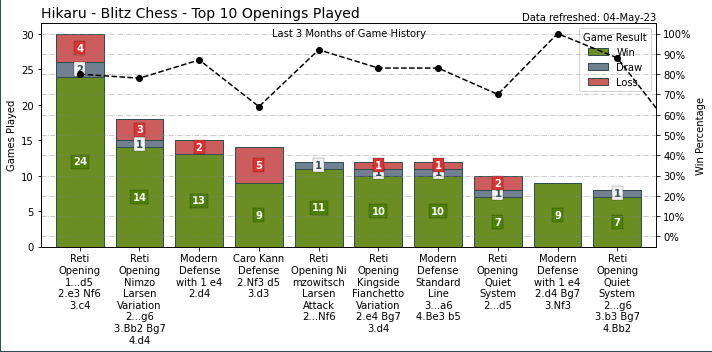

In [226]:
#Plotting chart
fig, ax = plt.subplots(figsize=(10,5),edgecolor='darkslategrey',linewidth=2)
df_openings_winLossDraw[0:number_of_openings].plot(kind='bar',ax=ax,stacked=True, color=['olivedrab','slategrey','indianred'],width=0.8,edgecolor='darkslategrey')
ax.set_title(f'{player} - Blitz Chess - Top {number_of_openings} Openings Played ',loc='left',fontsize=14)
ax.set_ylabel('Games Played', fontsize=10)
ax.set_xticklabels(opening_name_newlines[0:number_of_openings])
ax.text(x=1, y=1.05, s=f'Data refreshed: {today_str}', transform=ax.transAxes, va='top', ha='right')
ax.text(x=0.5, y=0.98, s=f'Last {last_x_months} Months of Game History', transform=ax.transAxes, va='top', ha='center')
plt.xticks(rotation=0)

#Plotting Win Rate on Dual Axis
ax2 = ax.twinx()
df_openings['Win Ratio'].plot(kind='line',ax = ax2, color='black',linestyle='--',marker='o')
ax2.set_yticks(np.arange(0,1.1,0.1))
ax2.set_ylabel('Win Percentage', fontsize=10)
y_fmt = mtick.PercentFormatter(xmax=1.0)
ax2.yaxis.set_major_formatter(y_fmt)

#Grid Lines
ax2.set_axisbelow(True)
ax2.grid(axis='y',linestyle='dashdot',color='grey',zorder=0,alpha=0.5)

#Setting a backround color
fig.set_facecolor('white')

#Text Annotations
open_annotation(df_openings[0:number_of_openings],'Win',ax,win_offset_list)
open_annotation(df_openings[0:number_of_openings],'Draw',ax,draw_offset_list)
open_annotation(df_openings[0:number_of_openings],'Loss',ax,loss_offset_list)
plt.tight_layout()

fig.savefig(
    'charts/top_openings.png',
    edgecolor=fig.get_edgecolor(),
    dpi=150
    )

#### Game Result Split by Time of Day

In [227]:
# Making a table with all the hours to eliminate discontinuity in dataset
hour_list = [i for i in range(24)]
hour_table = pd.DataFrame(hour_list,columns={'Hour'})

#Grouping data and performing right join to fill in potential gaps for the dims
df_time = df_blitz.groupby(['Hour','Game Result'])['rated'].count().reset_index(name='Games')
df_time = df_time.pivot(index='Hour',columns=['Game Result'],values='Games')
df_time = pd.merge(df_time,hour_table,on='Hour',how='right').fillna(0)
df_time['Hour'] = df_time['Hour'].astype(str)

#Creating a Table to split by result category in chart
df_time_winLossDraw = df_time[['Hour','Win','Draw','Loss']]

#Creating Offsets for Labels
[win_offset_list,draw_offset_list,loss_offset_list] = offsets(df_time_winLossDraw)

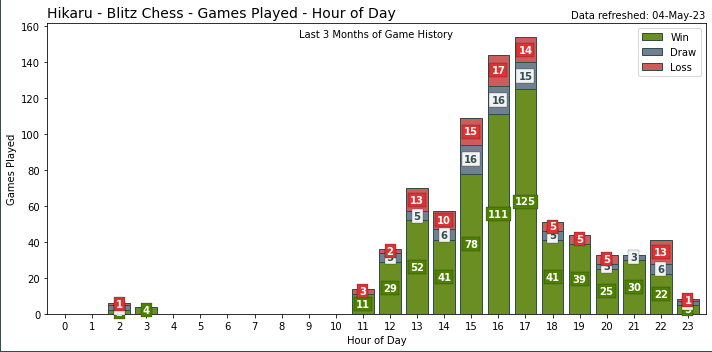

In [228]:
#Plotting Table
fig, ax = plt.subplots(figsize=(10,5),edgecolor='darkslategrey',linewidth=2)
# ax.bar(df_time['Hour'],df_time['Games'])
df_time_winLossDraw.plot(kind='bar',ax=ax,stacked=True, color=['olivedrab','slategrey','indianred'],width=0.8,edgecolor='darkslategrey')
ax.set_title(f'{player} - Blitz Chess - Games Played - Hour of Day',loc='left',fontsize=14)
ax.set_xlabel('Hour of Day', fontsize = 10)
ax.set_ylabel('Games Played', fontsize=10)
ax.text(x=1, y=1.045, s=f'Data refreshed: {today_str}', transform=ax.transAxes, va='top', ha='right')
ax.text(x=0.5, y=0.98, s=f'Last {last_x_months} Months of Game History', transform=ax.transAxes, va='top', ha='center')
plt.xticks(rotation=0)

#Setting a backround color
fig.set_facecolor('white')

#Text Annotations
open_annotation(df_time_winLossDraw,'Win',ax,win_offset_list)
open_annotation(df_time_winLossDraw,'Draw',ax,draw_offset_list)
open_annotation(df_time_winLossDraw,'Loss',ax,loss_offset_list)
plt.tight_layout()


plt.savefig(
    'charts/time_of_day.png',
    edgecolor=fig.get_edgecolor(),
    dpi=150
)

#### Game Result Split by Day of Week

In [229]:
# Making a table with all the day names to eliminate discontinuity in dataset
dayName_list = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
]
dayName_table = pd.DataFrame(dayName_list,columns={'Day Name'})

#Grouping data and performing right join to fill in potential gaps for the dims
df_day_name = df_blitz.groupby(['Day Name','Game Result'])['rated'].count().reset_index(name='Games')
df_day_name = df_day_name.pivot(index='Day Name',columns=['Game Result'],values='Games')
df_day_name = pd.merge(df_day_name,dayName_table,on='Day Name',how='right').fillna(0)

#Creating a Table to split by result category in chart
df_day_name_winLossDraw = df_day_name[['Day Name','Win','Draw','Loss']]

#Creating Offsets for Labels
[win_offset_list,draw_offset_list,loss_offset_list] = offsets(df_day_name_winLossDraw)

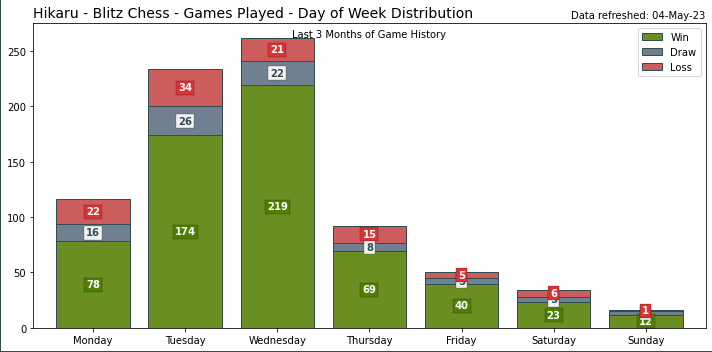

In [230]:
#Plotting Chart
fig, ax = plt.subplots(figsize=(10,5),edgecolor='darkslategrey',linewidth=2)
df_day_name_winLossDraw.plot(kind='bar',ax=ax,stacked=True, color=['olivedrab','slategrey','indianred'],width=0.8,edgecolor='darkslategrey')
ax.set_title(f'{player} - Blitz Chess - Games Played - Day of Week Distribution',loc='left',fontsize=14)
ax.set_xticklabels(df_day_name['Day Name'])
ax.text(x=1, y=1.045, s=f'Data refreshed: {today_str}', transform=ax.transAxes, va='top', ha='right')
ax.text(x=0.5, y=0.98, s=f'Last {last_x_months} Months of Game History', transform=ax.transAxes, va='top', ha='center')
plt.xticks(rotation=0)
plt.tight_layout()

#Setting a backround color
fig.set_facecolor('white')

#Text Annotations
open_annotation(df_day_name_winLossDraw,'Win',ax,win_offset_list)
open_annotation(df_day_name_winLossDraw,'Draw',ax,draw_offset_list)
open_annotation(df_day_name_winLossDraw,'Loss',ax,loss_offset_list)
plt.tight_layout()

plt.savefig(
    'charts/day_of_week.png',
    edgecolor=fig.get_edgecolor(),
    dpi=150
)

#### Volume of Activity

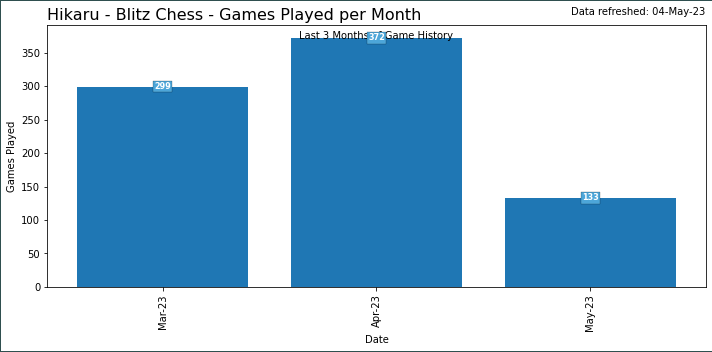

In [231]:
# Grouping Number of Games by Monthly Basis
df_activity = df_blitz.groupby(['Date'])['rated'].count()
df_activity = df_activity.groupby([pd.Grouper(level='Date',freq='M')]).sum().reset_index(name='Games')
for i in range(df_activity.shape[0]):
    df_activity.loc[i,'Date'] = df_activity.loc[i,'Date'].strftime("%b-%y")

fig, ax = plt.subplots(figsize=(10,5),edgecolor='darkslategrey',linewidth=2)
ax.bar(df_activity['Date'],df_activity['Games'])
ax.set_title(f'{player} - Blitz Chess - Games Played per Month',loc='left',fontsize=16)
ax.set_xlabel('Date', fontsize = 10)
ax.set_ylabel('Games Played', fontsize=10)
ax.text(x=1, y=1.07, s=f'Data refreshed: {today_str}', transform=ax.transAxes, va='top', ha='right')
ax.text(x=0.5, y=0.98, s=f'Last {last_x_months} Months of Game History', transform=ax.transAxes, va='top', ha='center')
plt.xticks(rotation=90)
plt.tight_layout()

#Setting a backround color
fig.set_facecolor('white')

#Text Annotations
chart_annotation(df_activity,'Games',ax,'bar')

plt.savefig(
    'charts/monthly_games.png',
    edgecolor=fig.get_edgecolor(),
    dpi=150
 )

#### Game Result Summary

In [232]:
def pie_chart_maker(table,title,center_text,category,count,output_file):

    # Arranging Data Labels
    game_total = sum(table[count])
    result_labels = []
    for i in range(table.shape[0]):
        result = table.at[i,category]
        game_count = table.at[i,count]
        result_labels.append(f'{result}\n{game_count}')

    # Plotting Summary of Results
    fig, ax = plt.subplots(figsize=(10, 5), linewidth = 1 ,subplot_kw=dict(aspect="equal"))

    # Setting a backround color
    fig.set_facecolor('white')

    # Creating pie elements
    if title == f'\nOverall Blitz Chess Summary:\n{player}':
        wedges, texts = ax.pie(table[count], colors=['slategrey','indianred','olivedrab'], wedgeprops=dict(width=0.5), startangle=-40)
    else:
        wedges, texts = ax.pie(table[count], wedgeprops=dict(width=0.5), startangle=-40)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="0", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    # Annotations
    ax.set_title(title,color='black',fontsize=13)
    ax.annotate(f'Games\n {center_text}:\n{game_total}', xy=(0, 0), xytext=(0, 0),
                horizontalalignment='center',fontsize = 10.5, **kw)

    # Creating Wedges
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(result_labels[i], xy=(x, y), xytext=(1.4*np.sign(x), 1.2*y),
                    horizontalalignment='center',fontsize = 9, **kw)

    # Date Refresh Text
    ax.text(x=0.5, y=1.0, s=f'Data refreshed: {today_str}', transform=ax.transAxes, va='top', ha='center')
    ax.text(x=0.5, y=0.95, s=f'Last {last_x_months} Months of Game History', transform=ax.transAxes, va='top', ha='center')
    
    plt.savefig(f'charts/{output_file}',edgecolor='darkslategrey',dpi=150)

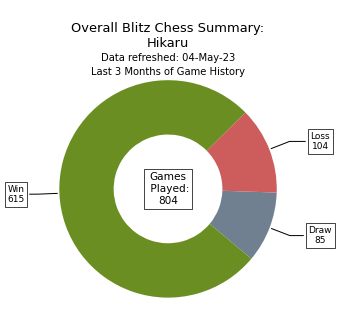

In [233]:
# Split by Game Result
table = df_blitz.groupby(['Game Result'])['rated'].count().reset_index(name='Games')
title = f'\nOverall Blitz Chess Summary:\n{player}'
center_text = 'Played'
category = 'Game Result'
count = 'Games'
output_file = 'chess_summary_pie.png'
pie_chart_maker(table,title,center_text,category,count,output_file)

In [234]:
# Split by End State
df_end_state_summary = df_blitz.groupby(['Game Result','End State'])['rated'].count().reset_index(name='Games')

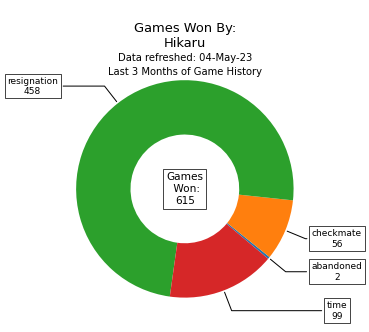

In [235]:
# Split by Winning End States
table = df_end_state_summary.loc[df_end_state_summary['Game Result']=='Win'].reset_index(drop=True)
title = f'\nGames Won By:\n{player}'
center_text = 'Won'
category = 'End State'
count = 'Games'
output_file = 'winning_end_pie.png'
pie_chart_maker(table,title,center_text,category,count,output_file)

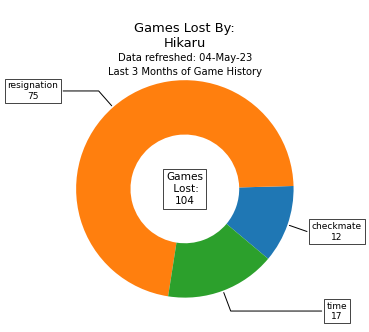

In [236]:
# Split by Losing End States
table = df_end_state_summary.loc[df_end_state_summary['Game Result']=='Loss'].reset_index(drop=True)
title = f'\nGames Lost By:\n{player}'
center_text = 'Lost'
category = 'End State'
count = 'Games'
output_file = 'losing_end_pie.png'
pie_chart_maker(table,title,center_text,category,count,output_file)

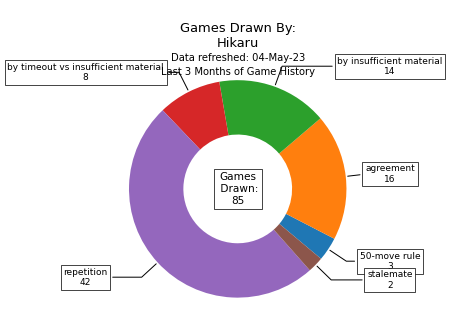

In [237]:
# Split by Drawn Status
table = df_end_state_summary.loc[df_end_state_summary['Game Result']=='Draw'].reset_index(drop=True)
title = f'\nGames Drawn By:\n{player}'
center_text = 'Drawn'
category = 'End State'
count = 'Games'
output_file = 'draw_end_pie.png'
pie_chart_maker(table,title,center_text,category,count,output_file)

# Plotting the Rating Change Over Time



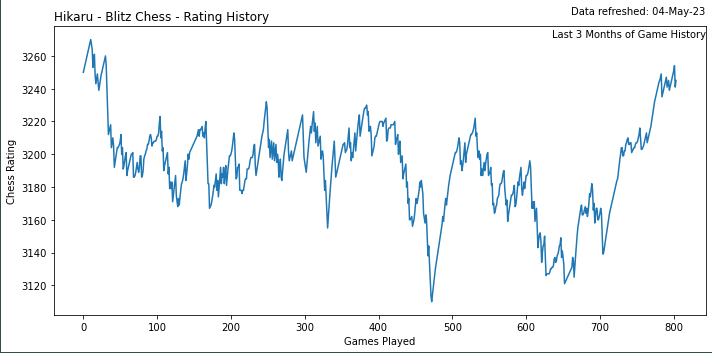

In [238]:
fig, ax = plt.subplots(figsize=(10,5),edgecolor='darkslategrey',linewidth=2)
ax.plot(df_blitz.index,df_blitz['Player Rating'])
# ax.plot(df_blitz.index,df_blitz['Opponent Rating'])
ax.set_title(f'{player} - Blitz Chess - Rating History',loc='left',fontsize=12)
ax.set_xlabel('Games Played', fontsize = 10)
ax.set_ylabel('Chess Rating', fontsize=10)
ax.text(x=1, y=1.07, s=f'Data refreshed: {today_str}', transform=ax.transAxes, va='top', ha='right')
ax.text(x=1, y=0.99, s=f'Last {last_x_months} Months of Game History', transform=ax.transAxes, va='top', ha='right')
plt.tight_layout()

#Setting a backround color
fig.set_facecolor('white')

plt.savefig(
    'charts/raw_rating_line.png',
    edgecolor=fig.get_edgecolor(),
    dpi=150
)

## Applying a moving Average on the Rating Data

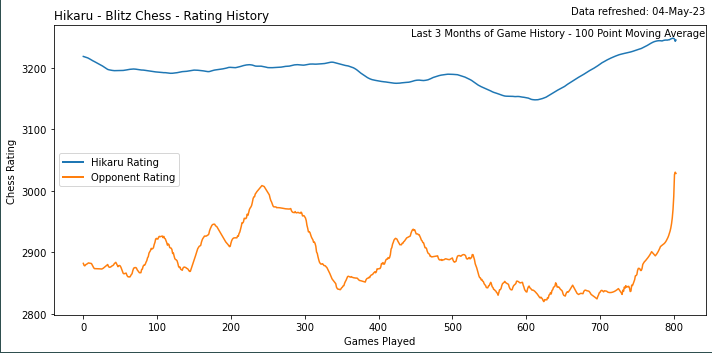

In [239]:
#Applying 100 point moving average
df_blitz_avg = df_blitz.copy()
window_size = 100
player_avg_data= []
opponent_avg_data= []
for i in range(df_blitz_avg.shape[0]):
    player_mov_avg = df_blitz_avg.loc[i:(i+window_size),'Player Rating'].mean()
    opponent_mov_avg = df_blitz_avg.loc[i:(i+window_size),'Opponent Rating'].mean()
    player_avg_data.append(player_mov_avg)
    opponent_avg_data.append(opponent_mov_avg)

#Appending list to dataframe
df_blitz_avg['Player Average Rating'] = player_avg_data
df_blitz_avg['Opponent Average Rating'] = opponent_avg_data

#Creating Legend Handle
legend_handle = [Line2D([0], [0], color='tab:blue', lw=2, label=f'{player} Rating'),
                 Line2D([0], [0], color='tab:orange', lw=2, linestyle='-', label='Opponent Rating'),
                ]

#Plotting Averaged Data
fig, ax = plt.subplots(figsize=(10,5),edgecolor='darkslategrey',linewidth=2)
ax.plot(df_blitz_avg.index,df_blitz_avg['Player Average Rating'])
ax.plot(df_blitz_avg.index,df_blitz_avg['Opponent Average Rating'])
ax.set_title(f'{player} - Blitz Chess - Rating History',loc='left',fontsize=12)
ax.set_xlabel('Games Played', fontsize = 10)
ax.set_ylabel('Chess Rating', fontsize=10)
ax.legend(handles=legend_handle,title_fontsize = 10, fontsize = 10)
ax.text(x=1, y=1.065, s=f'Data refreshed: {today_str}', transform=ax.transAxes, va='top', ha='right')
ax.text(x=1, y=0.99, s=f'Last {last_x_months} Months of Game History - {window_size} Point Moving Average', transform=ax.transAxes, va='top', ha='right')
plt.tight_layout()

#Setting a backround color
fig.set_facecolor('white')

plt.savefig(
    'charts/avg_rating_line.png',
    edgecolor=fig.get_edgecolor(),
    dpi=150
)

## Initialising XlsxWriter Workbook And Exporting Tables to .xlsx

In [246]:
#----------------------------------------------------------------------------------------------------------------------
#--------------------------------------------.xlsx workbook initialisation---------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

#Excel Output Filepath
excelpath = 'data/chess_data.xlsx'

#Generating .xlsx workbook in which to record dataframes for usage.
writer = pd.ExcelWriter(excelpath,engine='xlsxwriter')   
workbook=writer.book
worksheet='' #Initialise variable
startrow = 0 #Initialise variable
startcol = 0 #Initialise variable
v_idx = 0    #initialise counter to index vertical chart insertions
lr_pos = 0   #initialise left right insertion variable

#----------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------

In [247]:
#Summary Table
data_table = df_blitz[xlsx_columns]
sheet_name = 'Game Data'
title_str = f'Chess Games Played - {player}'
col_width_list = [22,30,30,106,13,50,12,13,14,15,17]
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(
    data_table,
    sheet_name,
    col_width_list,
    title_str,
    startrow,
    startcol,
    worksheet,
    workbook,
    writer
    )

In [248]:
#Openings Table
data_table = df_openings
sheet_name = 'Openings'
title_str = f'Chess Openings - {player}'
col_width_list = [106,6,6,6,14,11]
[startrow,startcol,worksheet,workbook,writer] = xlsx_table_writer(
    data_table,
    sheet_name,
    col_width_list,
    title_str,
    startrow,
    startcol,
    worksheet,
    workbook,
    writer
    )

In [249]:
# Adding and changing active sheet
sheet_name = 'Dashboard'
try:
    worksheet=workbook.add_worksheet(sheet_name)
    writer.sheets[sheet_name] = worksheet 
    worksheet.set_zoom(70)
except:
    pass

In [250]:
# Positioning matplotlib charts onto xlsx dashboard
worksheet.insert_image(1,5,'charts/raw_rating_line.png')
worksheet.insert_image(1,21,'charts/top_openings.png')
worksheet.insert_image(26,5,'charts/avg_rating_line.png')
worksheet.insert_image(26,21,'charts/time_of_day.png')
worksheet.insert_image(51,5,'charts/chess_summary_pie.png')
worksheet.insert_image(51,21,'charts/day_of_week.png')

0

In [251]:
#Save into Excel and Exit Python out of File
writer.close()